In [1]:
import json
from osgeo import gdal
import pdal
import os
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pprint import pprint
import laspy

gdal.UseExceptions()

FULL_BBOXES_PATH = "../../data/annotations_full/"
CROPPED_BBOXES_PATH = "../../data/annotations_cropped/"
FULL_IMAGES_PATH = "../../data/images_full/"
CROPPED_IMAGES_PATH = "../../data/images_cropped/"

# Create the output directories if they doesn't exist
if not os.path.exists(CROPPED_BBOXES_PATH):
    os.makedirs(CROPPED_BBOXES_PATH)
if not os.path.exists(CROPPED_IMAGES_PATH):
    os.makedirs(CROPPED_IMAGES_PATH)

In [2]:
# Define tile size and OVERLAP
TILE_SIZE = 1920  # Size of each tile
OVERLAP = 480  # Overlap between tiles

In [3]:
bboxes_path = FULL_BBOXES_PATH + "3"

with open(bboxes_path, "r") as file:
    # Load the annotation data
    bboxes_json = json.load(file)
    
    # Get the path to the full image
    full_image_path = bboxes_json["task"]["data"]["image"].replace("/data/local-files/?d=", "/")
    full_image_path_tif = full_image_path.replace(".png", ".tif")
    
    # Get the dimensions of the full image
    full_image = Image.open(full_image_path)
    full_image_width, full_image_height = full_image.size
    full_image_width_factor, full_image_height_factor = full_image_width / 100., full_image_height / 100.
    
    # Create the path
    output_image_prefix = os.path.splitext(os.path.basename(full_image_path_tif))[0]
    annotation_output_directory = os.path.join(CROPPED_BBOXES_PATH, output_image_prefix)
    if not os.path.exists(annotation_output_directory):
        os.makedirs(annotation_output_directory)
    
    # Calculate the number of rows and columns needed
    num_cols = int(np.ceil((full_image_width - OVERLAP) / (TILE_SIZE - OVERLAP)))
    num_rows = int(np.ceil((full_image_height - OVERLAP) / (TILE_SIZE - OVERLAP)))
    
    # Get the limits of all the cropped images
    cropping_limits_x = np.array([[i*(TILE_SIZE - OVERLAP), (i+1)*(TILE_SIZE - OVERLAP) + OVERLAP] for i in range(num_cols)])
    cropping_limits_y = np.array([[j*(TILE_SIZE - OVERLAP), (j+1)*(TILE_SIZE - OVERLAP) + OVERLAP] for j in range(num_rows)])
    
    bboxes_repartition = [[[] for _ in range(num_rows)] for _ in range(num_cols)]
    count = 0
    for index, bbox_info in enumerate(bboxes_json["result"]):
        bbox = bbox_info["value"]
        min_x = int(np.round(bbox["x"] * full_image_width_factor))
        min_y = int(np.round(bbox["y"] * full_image_height_factor))
        max_x = int(np.round((bbox["x"] + bbox["width"]) * full_image_width_factor))
        max_y = int(np.round((bbox["y"] + bbox["height"]) * full_image_height_factor))
        # Find the indices of the cropped images in which the bounding box fits
        i_x_0 = min_x // (TILE_SIZE - OVERLAP)
        i_y_0 = min_y // (TILE_SIZE - OVERLAP)
        
        found_image = False # To check if the bounding box fits entirely in at least one cropped image
        
        # Check the 4 possibilities
        if (max_x < (i_x_0+1)*(TILE_SIZE - OVERLAP) + OVERLAP):
            # First possible image (bottom right)
            if (max_y < (i_y_0+1)*(TILE_SIZE - OVERLAP) + OVERLAP):
                bboxes_repartition[i_x_0][i_y_0].append(index)
                found_image = True
            # Second possible image (top right)
            if (max_y < (i_y_0)*(TILE_SIZE - OVERLAP) + OVERLAP):
                bboxes_repartition[i_x_0][i_y_0-1].append(index)
                found_image = True
        if (max_x < (i_x_0)*(TILE_SIZE - OVERLAP) + OVERLAP):
            # Third possible image (bottom left)
            if (max_y < (i_y_0+1)*(TILE_SIZE - OVERLAP) + OVERLAP):
                bboxes_repartition[i_x_0-1][i_y_0].append(index)
                found_image = True
            # Fourth possible image (top left)
            if (max_y < (i_y_0)*(TILE_SIZE - OVERLAP) + OVERLAP):
                bboxes_repartition[i_x_0-1][i_y_0-1].append(index)
                found_image = True
        
        if (not found_image):
            raise Exception(f"The bounding box at index {index} doesn't fit entirely in any image.")
        
    # Create and store the cropped annotation files
    for row in tqdm(range(num_rows)):
        for col in tqdm(range(num_cols), leave=False):
            bboxes_dict = {
                "full_image": {
                    "path": full_image_path_tif,
                    "coordinates_of_cropped_image": {
                        "x": col*(TILE_SIZE - OVERLAP),
                        "y": row*(TILE_SIZE - OVERLAP),
                        "width": TILE_SIZE,
                        "height": TILE_SIZE,
                    },
                    "overlap": OVERLAP,
                },
                "col": col,
                "row": row,
                "width": TILE_SIZE,
                "height": TILE_SIZE,
                "bounding_boxes": [{
                        "id": bboxes_json["result"][i]["id"],
                        "index": i,
                        "x": bboxes_json["result"][i]["value"]["x"] * full_image_width_factor - col * (TILE_SIZE - OVERLAP),
                        "y": bboxes_json["result"][i]["value"]["y"] * full_image_width_factor - row * (TILE_SIZE - OVERLAP),
                        "width": bboxes_json["result"][i]["value"]["width"] * full_image_width_factor,
                        "height": bboxes_json["result"][i]["value"]["height"] * full_image_width_factor,
                        "label": bboxes_json["result"][i]["value"]["rectanglelabels"][0],
                } for i in bboxes_repartition[col][row]]
            }
            
            annotation_output_filename = f"{output_image_prefix}_{row}_{col}.json"
            output_path = os.path.join(annotation_output_directory, annotation_output_filename)
            with open(output_path, "w") as outfile: 
                json.dump(bboxes_dict, outfile)

/home/alexandre/miniforge3/envs/tree-segment/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (156250000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [4]:
# All this can also be done using gdal_retile.py

# Define output paths
image_output_directory = os.path.join(CROPPED_IMAGES_PATH, output_image_prefix)
if not os.path.exists(image_output_directory):
    os.makedirs(image_output_directory)

# Iterate over rows and columns to create tiles
for row in tqdm(range(num_rows)):
    for col in tqdm(range(num_cols), leave=False):
        # Calculate the pixel offsets for the tile
        x_offset = col * (TILE_SIZE - OVERLAP)
        y_offset = row * (TILE_SIZE - OVERLAP)

        # Create output filename
        output_filename = f"{output_image_prefix}_{row}_{col}.tif"
        output_path = os.path.join(image_output_directory, output_filename)

        # Define the subset area to read from the input image
        window = (x_offset, y_offset, TILE_SIZE, TILE_SIZE)

        gdal.Translate(output_path, full_image_path_tif, srcWin=window)

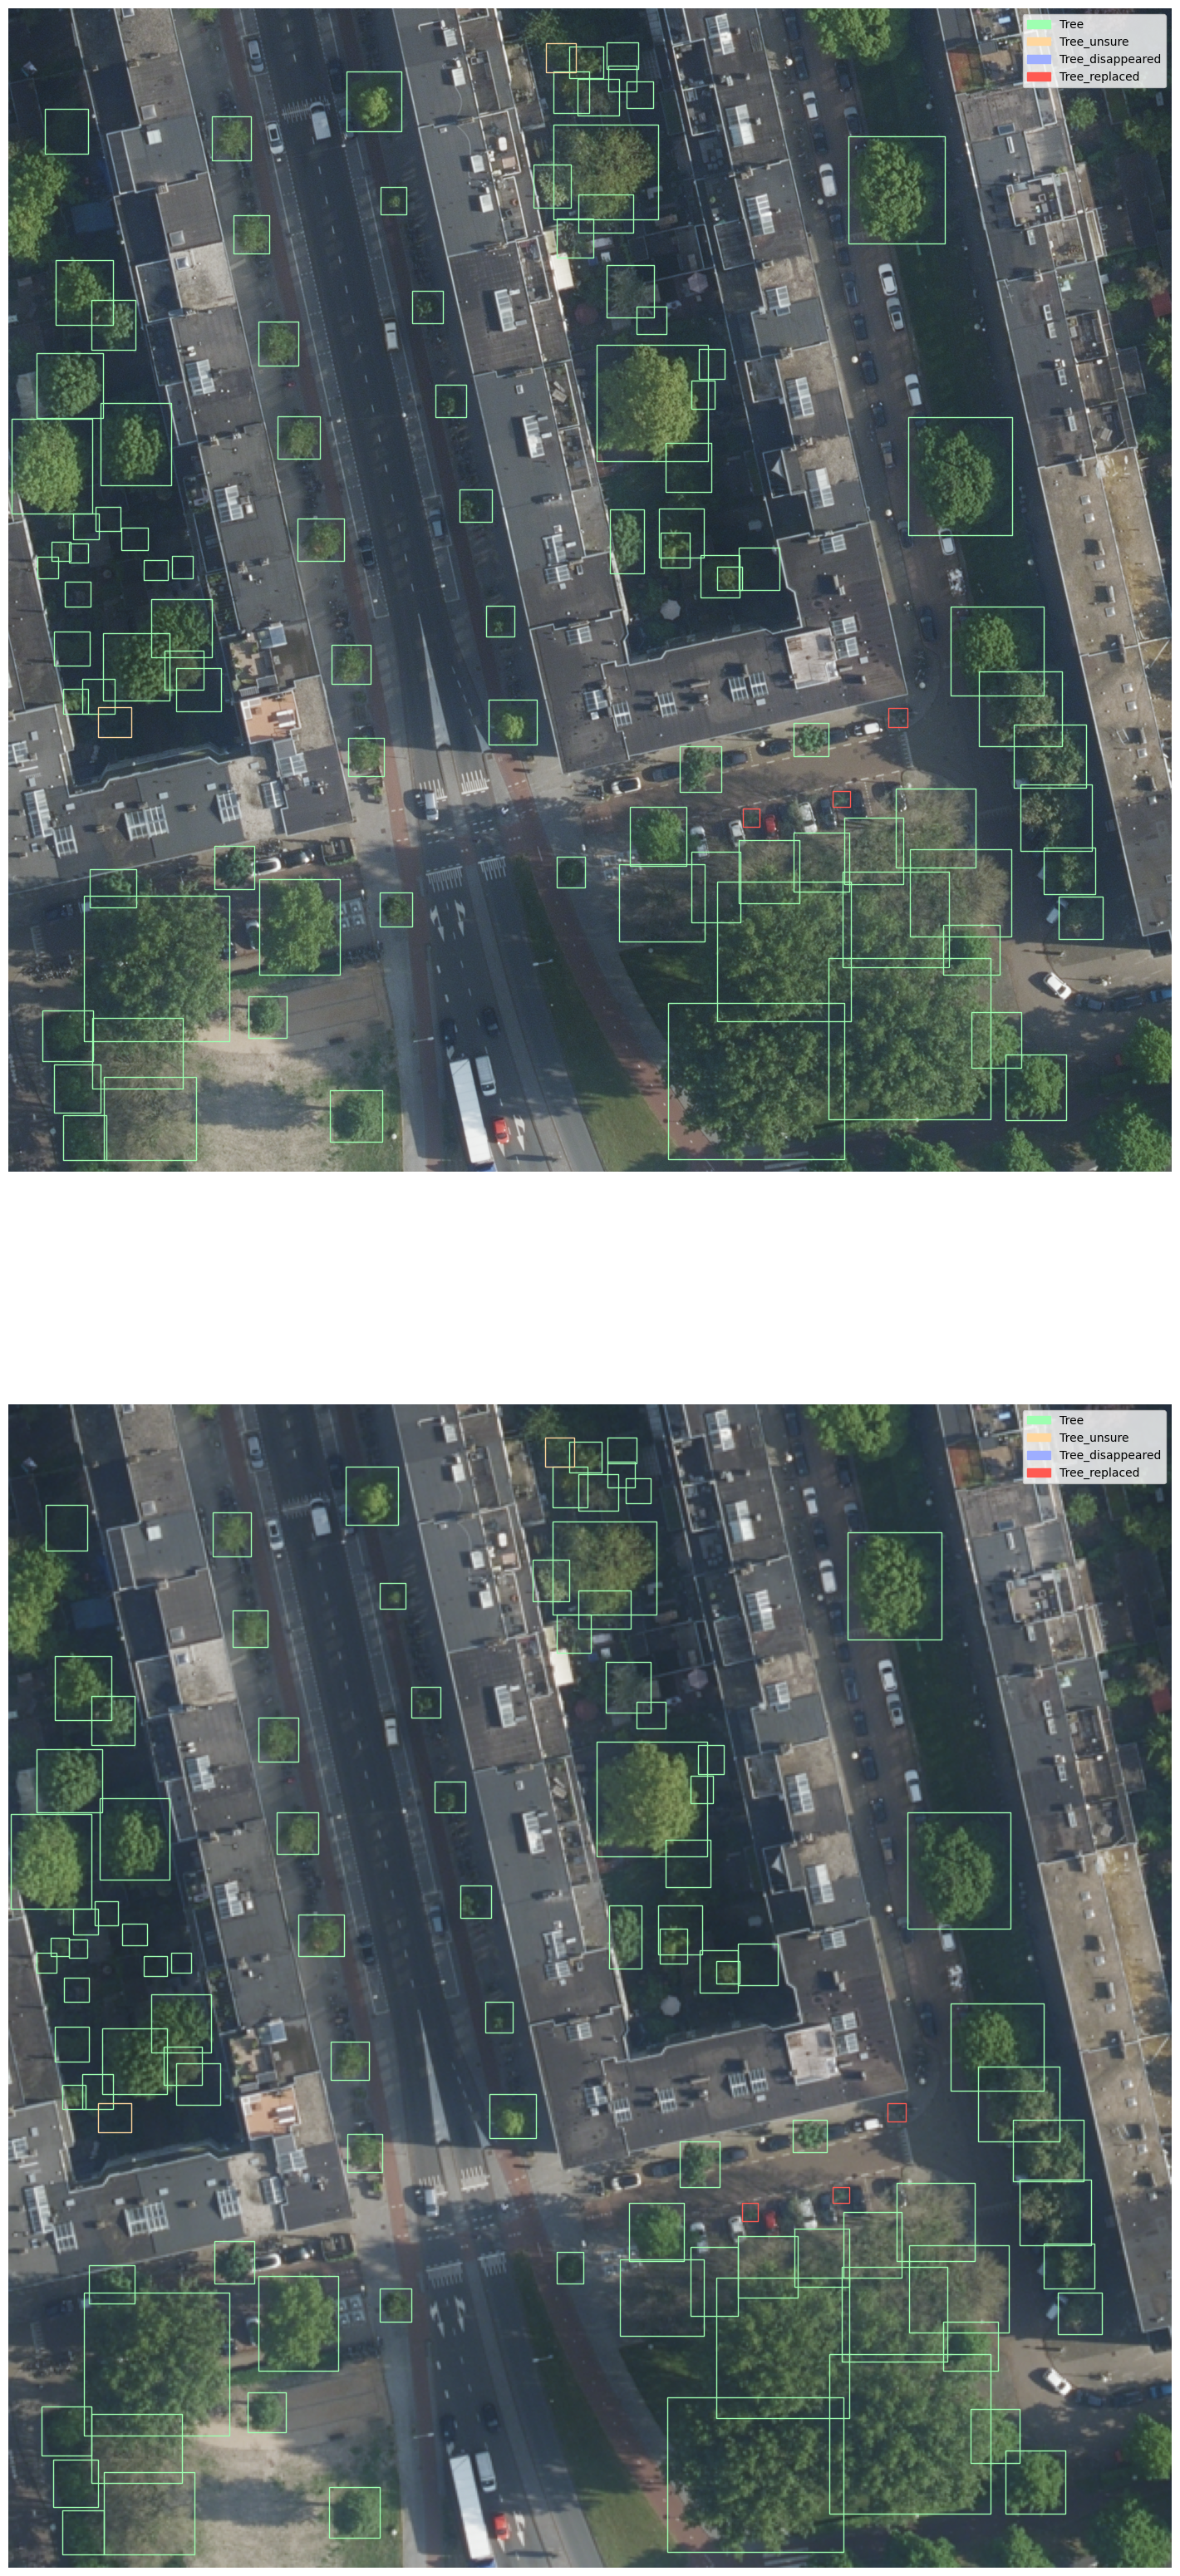

In [5]:
def display_image_with_boxes(image_path: str, boxes: list | None=None) -> None:
    reduction_ratio = 3
    
    # Load image
    image = Image.open(image_path)
    image_smaller = Image.open(image_path)
    image_smaller.thumbnail((TILE_SIZE//reduction_ratio, TILE_SIZE//reduction_ratio))

    # Create figure and axis
    fig, axs = plt.subplots(2, 1, figsize=(20, 40))
    
    # Display image
    axs[0].imshow(image)
    axs[1].imshow(image_smaller)
    
    # Annotation colors
    colors = {
        "Tree": "#9effb1",
        "Tree_unsure": "#ffd79e",
        "Tree_disappeared": "#9eaeff",
        "Tree_replaced": "#ff5a52",
    }
    
    # Add bounding boxes if provided
    if boxes:
        for box in boxes:
            # Extract box coordinates
            x, y, width, height, label = box
            # Create a Rectangle patch
            rect = Rectangle((x, y), width, height, linewidth=1, edgecolor=colors[label], facecolor='none')
            # Add the patch to the Axes
            axs[0].add_patch(rect)
            # Create a Rectangle patch
            rect = Rectangle((x//reduction_ratio, y//reduction_ratio), width//reduction_ratio, height//reduction_ratio, linewidth=1, edgecolor=colors[label], facecolor='none')
            # Add the patch to the Axes
            axs[1].add_patch(rect)
    
    # Add each rectangle to the legend individually
    for label, color in colors.items():
        axs[0].add_patch(Rectangle((0,0), 0, 0, color=color, label=label))
        axs[1].add_patch(Rectangle((0,0), 0, 0, color=color, label=label))
    
    axs[0].set_axis_off()
    axs[0].legend()
    axs[1].set_axis_off()
    axs[1].legend()
    
    # Show plot
    plt.show()
    
def get_bounding_boxes(bboxes_path: str) -> list:
    with open(bboxes_path, "r") as file:
        # Load the annotation data
        bboxes_json = json.load(file)
        
        # Get every bounding box
        bboxes = []
        for bbox in bboxes_json["bounding_boxes"]:
            bboxes.append((bbox["x"], bbox["y"], bbox["width"], bbox["height"], bbox["label"]))
            
    return bboxes

image_path = "../../data/images_cropped/2023_122000_484000_RGB_hrl/2023_122000_484000_RGB_hrl_1_2.tif"
bboxes_path = "../../data/annotations_cropped/2023_122000_484000_RGB_hrl/2023_122000_484000_RGB_hrl_1_2.json"

bboxes = get_bounding_boxes(bboxes_path)
display_image_with_boxes(image_path, bboxes)

In [6]:

def crop_las(input_las_list: list[str], output_las: str, x_limits: tuple, y_limits: tuple):
    if x_limits[0] > x_limits[1]:
        raise Exception("You should have x_limits[0] <= x_limits[1]")
    if y_limits[0] > y_limits[1]:
        raise Exception("You should have y_limits[0] <= y_limits[1]")
    bounds = f"([{x_limits[0]},{x_limits[1]}],[{y_limits[0]},{y_limits[1]}])"
    pipeline_list = []
    for index, input_las in enumerate(input_las_list):
         pipeline_list.append({
            "type": "readers.las",
            "filename": input_las,
            "tag": f"A{index}"
        })
    pipeline_list.extend([{
            "type": "filters.merge",
            "inputs": [f"A{index}" for index in range(len(input_las_list))]
        },
        {
            "type": "filters.crop",
            "bounds": bounds
        },
        {
            "type": "filters.range",
            "limits": "Classification[1:5]"  # Keep only unclassified, ground and vegetation
        },
        {
            "type": "writers.las",
            "filename": output_las
        }
    ])
    pprint(json.dumps(pipeline_list))
    pipeline = pdal.Pipeline(json.dumps(pipeline_list))
    pipeline.execute()
# Open the GeoTIFF file
ds = gdal.Open(full_image_path_tif)
# Get the geotransform parameters
gt = ds.GetGeoTransform()
# Calculate the image coordinates
width = ds.RasterXSize
height = ds.RasterYSize
# Calculate the coordinates of the four corners
x1 = int(gt[0])
y1 = int(gt[3])
x2 = int(gt[0] + (gt[1] * width)/10)
y2 = int(gt[3] + (gt[5] * height)/10)
# Close the dataset
ds = None
# Crop the point cloud
huge_point_cloud_path = ["../../data/point_clouds_huge/25GN1_13.LAZ", "../../data/point_clouds_huge/25GN1_18.LAZ"]
full_point_cloud_path = f"../../data/point_clouds_full/{int(x1)}_{int(y1)}_with_duplicates_2.las"
crop_las(huge_point_cloud_path, full_point_cloud_path, (x1, x2), (y2, y1))

('[{"type": "readers.las", "filename": '
 '"../../data/point_clouds_huge/25GN1_13.LAZ", "tag": "A0"}, {"type": '
 '"readers.las", "filename": "../../data/point_clouds_huge/25GN1_18.LAZ", '
 '"tag": "A1"}, {"type": "filters.merge", "inputs": ["A0", "A1"]}, {"type": '
 '"filters.crop", "bounds": "([122000,122100],[483900,484000])"}, {"type": '
 '"filters.range", "limits": "Classification[1:5]"}, {"type": "writers.las", '
 '"filename": '
 '"../../data/point_clouds_full/122000_484000_with_duplicates_2.las"}]')


In [13]:
def remove_duplicate_points(input_las_file, output_las_file):
    # Open the input LAS file
    in_las = laspy.read(input_las_file)
    # Convert coordinates and all dimensions to a NumPy array
    points = np.column_stack([getattr(in_las, dim) for dim in in_las.point_format.dimension_names])
    # Find unique points
    unique_points, idx = np.unique(points, axis=0, return_index=True)
    # Extract unique coordinates
    num_points = len(unique_points)
    # Create a new LAS file
    out_header = in_las.header
    out_header.point_count = num_points
    out_las = laspy.LasData(out_header)
    # Set all dimensions in the output LAS file
    for dim_idx, dim_name in enumerate(in_las.point_format.dimension_names):
        dim_values = unique_points[:, dim_idx]
        # If the dimension is not used, don't set it
        if np.all(dim_values == dim_values[0]):
            print(dim_name)
            continue
        setattr(out_las, dim_name, dim_values)
    out_las.write(output_las_file)
    
def las_to_laz(input_las_path: str):
    input_las_path_no_extension, initial_extension = os.path.splitext(input_las_path)
    if (initial_extension not in [".las", ".LAS"]):
        raise Exception("The input must be a LAS file.")
    output_laz_path = input_las_path_no_extension + ".laz"
    pipeline_list = [{
            "type": "readers.las",
            "filename": input_las_path,
        },
        {
            "type": "writers.las",
            "filename": output_laz_path
        }
    ]
    pprint(json.dumps(pipeline_list))
    pipeline = pdal.Pipeline(json.dumps(pipeline_list))
    pipeline.execute()

# Usage
input_las_file = "../../data/point_clouds_full/122000_484000_with_duplicates_2.las"
output_las_file = "../../data/point_clouds_full/122000_484000_2.laz"
output_las_file_2 = "../../data/point_clouds_full/122000_484000_3_2.las"
las_to_laz(input_las_file)
remove_duplicate_points(input_las_file, output_las_file)
remove_duplicate_points(input_las_file, output_las_file_2)
las_to_laz(output_las_file_2)

edge_of_flight_line
synthetic
key_point
withheld
point_source_id
('[{"type": "readers.las", "filename": '
 '"../../data/point_clouds_full/122000_484000_with_duplicates_2.las"}, '
 '{"type": "writers.las", "filename": '
 '"../../data/point_clouds_full/122000_484000_with_duplicates_2.laz"}]')
edge_of_flight_line
synthetic
key_point
withheld
point_source_id
('[{"type": "readers.las", "filename": '
 '"../../data/point_clouds_full/122000_484000_3_2.las"}, {"type": '
 '"writers.las", "filename": '
 '"../../data/point_clouds_full/122000_484000_3_2.laz"}]')
